### **Description**

Recipe showing how to extract the Overturning in the Subpolar North Atlantic (OSNAP) trans-basin hydrographic section using annual-mean outputs from the National Oceanography Centre Near-Present-Day global eORCA1 configuration of NEMO forced using ERA-5 climatologically adjusted atmospheric forcing from 1976-2024.

For more details on this model configuration and the available outputs, users can explore the Near-Present-Day documentation [here](https://noc-msm.github.io/NOC_Near_Present_Day/).

---
### **Background**
The Overturning in the Subpolar North Atlantic Program (OSNAP) is an international program designed to provide a continuous record of the full-water column, trans-basin fluxes of heat, mass and freshwater in the subpolar North Atlantic.

The OSNAP observing system comprises of two trans-basin arrays: extending from southern Labrador to the southwestern tip of Greenland across the Labrador Sea (OSNAP West), and from the southeastern tip of Greenland to Scotland (OSNAP East).

The diapycnal overturning stream function is used to characterise the strength and structure of the AMOC in density-space (e.g., $\sigma_{0}$ or $\sigma_{2}$) across OSNAP and can be defined at time $t$ as follows:

$$\Psi_{\sigma}(\sigma, t) = \int_{\sigma_{min}}^{\sigma} \int_{x_w}^{x_e} v(x, \sigma, t) \ dx \ d\sigma$$

where the velocity field $v(x, \sigma, t)$ normal to OSNAP is first integrated zonally between the western $x_w$ and eastern $x_e$ boundaries of the basin, before being accumulated from the sea surface $\sigma_{min}$ to a specified isopycnal $\sigma$.

---

In [1]:
# -- Import required packages -- #
import gsw
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from nemo_cookbook import NEMODataTree

xr.set_options(display_style="text")

### **Using Dask**

**Optional: Connect Client to Dask Local Cluster to run analysis in parallel.**

Note that, although using Dask is not strictly necessary for this simple example using eORCA1, if we wanted to generalise this recipe to eORCA025 or eORCA12 outputs, using Dask would be essential to avoid unnecessary slow calculations using only a single process.

In [ ]:
# -- Initialise Dask Local Cluster -- #
import dask
from dask.distributed import Client, LocalCluster

# Update temporary directory for Dask workers:
dask.config.set({'temporary_directory': '/dssgfs01/working/otooth/Diagnostics/nemo_cookbook/recipes/',
                 'local_directory': '/dssgfs01/working/otooth/Diagnostics/nemo_cookbook/recipes/'
                 })

# Create Local Cluster:
cluster = LocalCluster(n_workers=5, threads_per_worker=2, memory_limit='8GB')
client = Client(cluster)
client

### **Accessing NEMO Model Data**
**Let's begin by loading the grid variables for our eORCA1 NEMO model from the [JASMIN Object Store](https://help.jasmin.ac.uk/docs/short-term-project-storage/using-the-jasmin-object-store/)**. 

**Alternatively, you can replace the ``domain_filepath`` below with a file path to your domain_cfg.nc file and read this with xarray's ``open_dataset()`` function.**

In [2]:
# Define directory path to ancillary files:
domain_filepath = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca025-jra55v1/domain"

# Open eORCA1 NEMO model domain_cfg:
ds_domain = (xr.open_zarr(f"{domain_filepath}/domain_cfg", consolidated=True, chunks={})
             .squeeze()
             .rename({'z': 'nav_lev'})
             )

ds_domain.load()

<xarray.Dataset> Size: 8GB
Dimensions:       (y: 1206, x: 1440, nav_lev: 75)
Dimensions without coordinates: y, x, nav_lev
Data variables: (12/43)
    e1v           (y, x) float64 14MB 1e+03 1e+03 1e+03 ... 5.653e+03 3.28e+03
    closea_mask   (y, x) float64 14MB nan nan nan nan 11.0 ... nan nan nan nan
    bottom_level  (y, x) int32 7MB 0 0 0 0 5 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    e1u           (y, x) float64 14MB 1e+03 1e+03 1e+03 ... 6.277e+03 5.038e+03
    e2t           (y, x) float64 14MB 1e+03 1e+03 1e+03 ... 683.6 925.0 1.135
    e1t           (y, x) float64 14MB 1e+03 1e+03 1e+03 ... 6.516e+03 5.79e+03
    ...            ...
    nav_lat       (y, x) float32 7MB -89.5 -89.5 -89.5 ... 50.07 50.02 50.0
    mask_opensea  (y, x) float64 14MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nav_lev       (nav_lev) float32 300B 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lon       (y, x) float32 7MB 73.0 73.25 73.5 73.75 ... 73.0 73.0 73.0
    top_level     (y, x) int32 7MB 0 0 0 0 1 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    time_counter  float64 8B 0.0
Attributes: (12/14)
    DOMAIN_number_total:     1
    DOMAIN_number:           0
    DOMAIN_dimensions_ids:   [1, 2]
    DOMAIN_size_global:      [1442, 1207]
    DOMAIN_size_local:       [1442, 1207]
    DOMAIN_position_first:   [1, 1]
    ...                      ...
    DOMAIN_halo_size_end:    [0, 0]
    DOMAIN_type:             BOX
    cn_cfg:                  orca
    history:                 Thu Feb  3 15:18:00 2022: ncks --4 --no_abc --cn...
    nn_cfg:                  25
    NCO:                     netCDF Operators version 4.9.5 (Homepage = http:...

**Next, we need to import the conservative temperature and absolute salinity stored at T-points in a single dataset.**

**Typically, NEMO model outputs defined on T-grid points are stored together in netCDF files. In this case, you can replace `xr.merge()` with a single call to xarray's `open_dataset()` function passing the file path to your `_gridT.nc` file(s).**

In [3]:
# Define directory path to model output files:
output_dir = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca025-jra55v1/T1y"

# Construct NEMO model grid dataset, including vertical grid cell thicknesses (m) and meridional velocities (m/s):
ds_gridT = xr.merge([xr.open_zarr(f"{output_dir}/{var}", consolidated=True, chunks={})[var] for var in ['thetao_con', 'so_abs']], compat="override")
ds_gridT = ds_gridT.sel(time_counter=slice("2014-01", "2023-12"))

# Calculate potential density anomaly referenced to the sea surface (kg/m3):
ds_gridT['sigma0'] = gsw.density.sigma0(CT=ds_gridT['thetao_con'], SA=ds_gridT['so_abs'])
ds_gridT['sigma0'].name = 'sigma0'

ds_gridT

<xarray.Dataset> Size: 21GB
Dimensions:        (deptht: 75, y: 1206, x: 1440, time_counter: 10)
Coordinates:
  * deptht         (deptht) float32 300B 0.5058 1.556 ... 5.698e+03 5.902e+03
  * time_counter   (time_counter) datetime64[ns] 80B 2014-07-02T12:00:00 ... ...
    nav_lat        (y, x) float64 14MB dask.array<chunksize=(603, 720), meta=np.ndarray>
    nav_lon        (y, x) float64 14MB dask.array<chunksize=(603, 720), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] 80B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    thetao_con     (time_counter, deptht, y, x) float32 5GB dask.array<chunksize=(1, 25, 603, 720), meta=np.ndarray>
    so_abs         (time_counter, deptht, y, x) float32 5GB dask.array<chunksize=(1, 25, 603, 720), meta=np.ndarray>
    sigma0         (time_counter, deptht, y, x) float64 10GB dask.array<chunksize=(1, 25, 603, 720), meta=np.ndarray>
Attributes:
    cell_methods:        time: mean
    interval_operation:  1 yr
    interval_write:      1 yr
    long_name:           sea_water_conservative_temperature
    online_operation:    average
    standard_name:       sea_water_conservative_temperature
    units:               degC

**Next, we need to import the zonal & meridional velocities and vertical grid cell thicknesses stored at U- & V-points, respectively.**

**Typically, NEMO model outputs defined on U- & V-grid points are stored together in netCDF files. In this case, you can replace `xr.merge()` with a single call to xarray's `open_dataset()` function passing the file path to your `_gridV.nc` file(s).**

In [4]:
# Define directory path to model output files:
output_dir = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca025-jra55v1/U1y"

# Construct NEMO model grid dataset, including vertical grid cell thicknesses (m) and meridional velocities (m/s):
ds_gridU = xr.merge([xr.open_zarr(f"{output_dir}/{var}", consolidated=True, chunks={})[var] for var in ['e3u', 'uo']], compat="override")
ds_gridU = ds_gridU.sel(time_counter=slice("2014-01", "2023-12"))

ds_gridU

<xarray.Dataset> Size: 10GB
Dimensions:        (depthu: 75, y: 1206, x: 1440, time_counter: 10)
Coordinates:
  * depthu         (depthu) float32 300B 0.5058 1.556 ... 5.698e+03 5.902e+03
  * time_counter   (time_counter) datetime64[ns] 80B 2014-07-02T12:00:00 ... ...
    nav_lat        (y, x) float64 14MB dask.array<chunksize=(603, 720), meta=np.ndarray>
    nav_lon        (y, x) float64 14MB dask.array<chunksize=(603, 720), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] 80B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    e3u            (time_counter, depthu, y, x) float32 5GB dask.array<chunksize=(1, 25, 603, 720), meta=np.ndarray>
    uo             (time_counter, depthu, y, x) float32 5GB dask.array<chunksize=(1, 25, 603, 720), meta=np.ndarray>
Attributes:
    cell_methods:        time: mean (interval: 1800 s)
    interval_operation:  1800 s
    interval_write:      1 yr
    long_name:           U-cell thickness
    online_operation:    average
    standard_name:       cell_thickness
    units:               m

In [5]:
# Define directory path to model output files:
output_dir = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca025-jra55v1/V1y"

# Construct NEMO model grid dataset, including vertical grid cell thicknesses (m) and meridional velocities (m/s):
ds_gridV = xr.merge([xr.open_zarr(f"{output_dir}/{var}", consolidated=True, chunks={})[var] for var in ['e3v', 'vo']], compat="override")
ds_gridV = ds_gridV.sel(time_counter=slice("2014-01", "2023-12"))

ds_gridV

<xarray.Dataset> Size: 10GB
Dimensions:        (depthv: 75, y: 1206, x: 1440, time_counter: 10)
Coordinates:
  * depthv         (depthv) float32 300B 0.5058 1.556 ... 5.698e+03 5.902e+03
  * time_counter   (time_counter) datetime64[ns] 80B 2014-07-02T12:00:00 ... ...
    nav_lat        (y, x) float64 14MB dask.array<chunksize=(603, 720), meta=np.ndarray>
    nav_lon        (y, x) float64 14MB dask.array<chunksize=(603, 720), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] 80B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    e3v            (time_counter, depthv, y, x) float32 5GB dask.array<chunksize=(1, 25, 603, 720), meta=np.ndarray>
    vo             (time_counter, depthv, y, x) float32 5GB dask.array<chunksize=(1, 25, 603, 720), meta=np.ndarray>
Attributes:
    cell_methods:        time: mean (interval: 1800 s)
    interval_operation:  1800 s
    interval_write:      1 yr
    long_name:           V-cell thickness
    online_operation:    average
    standard_name:       cell_thickness
    units:               m

### **Creating a NEMODataTree**

**Next, let's create a NEMODataTree to store our domain and T, U & V-grid variables for the eORCA1 model.**

In [6]:
# Define dictionary of grid datasets defining eORCA1 parent model domain with no child/grand-child nests:
# Note: domain_cfg z-dimension is expected to be named 'nav_lev'.
datasets = {"parent":
            {"domain": ds_domain,
             "gridT": ds_gridT,
             "gridU": ds_gridU,
             "gridV": ds_gridV
             }
            }

# Initialise a new NEMODataTree whose parent domain is zonally periodic & north-folding on F-points:
nemo = NEMODataTree.from_datasets(datasets=datasets, iperio=True, nftype="T")

nemo

<xarray.DataTree>
Group: /
│   Dimensions:        (time_counter: 10)
│   Coordinates:
│     * time_counter   (time_counter) datetime64[ns] 80B 2014-07-02T12:00:00 ... ...
│       time_centered  (time_counter) datetime64[ns] 80B dask.array<chunksize=(1,), meta=np.ndarray>
│   Attributes:
│       nftype:   T
│       iperio:   True
├── Group: /gridT
│       Dimensions:        (time_counter: 10, k: 75, j: 1206, i: 1440)
│       Coordinates:
│         * k              (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j              (j) int64 10kB 1 2 3 4 5 6 ... 1201 1202 1203 1204 1205 1206
│         * i              (i) int64 12kB 1 2 3 4 5 6 ... 1435 1436 1437 1438 1439 1440
│         * deptht         (k) float32 300B 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
│           time_centered  (time_counter) datetime64[ns] 80B dask.array<chunksize=(1,), meta=np.ndarray>
│           gphit          (j, i) float64 14MB -89.5 -89.5 -89.5 ... 50.07 50.02 50.0
│           glamt          (j, i) float64 14MB 73.0 73.25 73.5 73.75 ... 73.0 73.0 73.0
│       Data variables:
│           thetao_con     (time_counter, k, j, i) float32 5GB dask.array<chunksize=(1, 25, 603, 720), meta=np.ndarray>
│           so_abs         (time_counter, k, j, i) float32 5GB dask.array<chunksize=(1, 25, 603, 720), meta=np.ndarray>
│           sigma0         (time_counter, k, j, i) float64 10GB dask.array<chunksize=(1, 25, 603, 720), meta=np.ndarray>
│           e1t            (j, i) float64 14MB 1e+03 1e+03 1e+03 ... 6.516e+03 5.79e+03
│           e2t            (j, i) float64 14MB 1e+03 1e+03 1e+03 ... 683.6 925.0 1.135
│           top_level      (j, i) int32 7MB 0 0 0 0 1 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
│           bottom_level   (j, i) int32 7MB 0 0 0 0 5 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
│           tmask          (k, j, i) bool 130MB False False False ... False False False
│           tmaskutil      (j, i) bool 2MB False False False False ... False False False
│       Attributes:
│           nftype:   T
│           iperio:   True
├── Group: /gridU
│       Dimensions:        (time_counter: 10, k: 75, j: 1206, i: 1440)
│       Coordinates:
│         * k              (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j              (j) int64 10kB 1 2 3 4 5 6 ... 1201 1202 1203 1204 1205 1206
│         * i              (i) float64 12kB 1.5 2.5 3.5 ... 1.438e+03 1.44e+03 1.44e+03
│         * depthu         (k) float32 300B 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
│           time_centered  (time_counter) datetime64[ns] 80B dask.array<chunksize=(1,), meta=np.ndarray>
│           gphiu          (j, i) float64 14MB -89.5 -89.5 -89.5 ... 50.04 50.01 50.0
│           glamu          (j, i) float64 14MB 73.12 73.38 73.62 ... 73.0 73.0 73.0
│       Data variables:
│           e3u            (time_counter, k, j, i) float32 5GB dask.array<chunksize=(1, 25, 603, 720), meta=np.ndarray>
│           uo             (time_counter, k, j, i) float32 5GB dask.array<chunksize=(1, 25, 603, 720), meta=np.ndarray>
│           e1u            (j, i) float64 14MB 1e+03 1e+03 1e+03 ... 6.277e+03 5.038e+03
│           e2u            (j, i) float64 14MB 1e+03 1e+03 1e+03 ... 847.0 455.1 151.3
│           umask          (k, j, i) bool 130MB False False False ... False False False
│           umaskutil      (j, i) bool 2MB False False False False ... False False False
│       Attributes:
│           cell_methods:        time: mean (interval: 1800 s)
│           interval_operation:  1800 s
│           interval_write:      1 yr
│           long_name:           U-cell thickness
│           online_operation:    average
│           standard_name:       cell_thickness
│           units:               m
│           nftype:              T
│           iperio:              True
├── Group: /gridV
│       Dimensions:        (time_counter: 10, k: 75, j: 1206, i: 1440)
│       Coordinates:
│         * k              (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 7

### **Preparing OSNAP Coordinates**

**Next, we will prepare geographical (lat, lon) coordinates defining the Overturning in the Subpolar North Atlantic (OSNAP) array from the [JASMIN Object Store](https://help.jasmin.ac.uk/docs/short-term-project-storage/using-the-jasmin-object-store/).**


In [7]:
# Define S3 URL to OSNAP gridded observational data in JASMIN Object Store:
url = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/ocean-obs/OSNAP/OSNAP_Gridded_TSV_201408_202006_2023"
ds_osnap = xr.open_zarr(url, consolidated=True, chunks={})

# Define OSNAP section coordinates (adding final land point - UK):
lon_osnap = np.concatenate([ds_osnap['LONGITUDE'].values, np.array([-4.0])])
lat_osnap = np.concatenate([ds_osnap['LATITUDE'].values, np.array([56.0])])

### **Extracting the OSNAP array as a continuous hydrographic section**

**Now, let's use the `extract_section()` function to extract the OSNAP array from our NEMO model output.**

**We need to provide the names of the zonal & meridional velocity variables (`uv_vars=["uo", "vo"]`) and any scalar variables (e.g. potential density `vars=sigma0`) to extract along the secton.**

In [8]:
# Extract the OSNAP section from the NEMO model data:
ds_osnap = nemo.extract_section(lon_section=lon_osnap,
                                lat_section=lat_osnap,
                                uv_vars=["uo", "vo"],
                                vars=["sigma0"],
                                dom=".",
                                )

ds_osnap

<xarray.Dataset> Size: 5MB
Dimensions:       (bdy: 277, time_counter: 10, k: 75)
Coordinates:
  * bdy           (bdy) int64 2kB 0 1 2 3 4 5 6 ... 270 271 272 273 274 275 276
  * time_counter  (time_counter) datetime64[ns] 80B 2014-07-02T12:00:00 ... 2...
  * k             (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
    glamb         (bdy) float64 2kB -56.75 -56.5 -56.24 ... -4.712 -4.441 -4.171
    gphib         (bdy) float64 2kB 52.09 52.11 52.13 ... 56.13 56.11 56.09
    depthb        (k, bdy) float64 166kB 0.5058 0.5058 ... 5.902e+03 5.902e+03
Data variables:
    i_bdy         (bdy) float64 2kB 927.0 928.0 929.0 ... 1.123e+03 1.124e+03
    j_bdy         (bdy) float64 2kB 932.5 932.5 932.5 ... 955.5 955.5 955.5
    flux_type     (bdy) <U1 1kB 'V' 'V' 'V' 'V' 'V' 'V' ... 'V' 'U' 'V' 'V' 'V'
    flux_dir      (bdy) int64 2kB 1 1 1 1 1 1 1 1 1 -1 1 ... 1 1 1 1 1 1 1 1 1 1
    velocity      (time_counter, k, bdy) float64 2MB dask.array<chunksize=(10, 75, 277), meta=np.ndarray>
    e1b           (bdy) float64 2kB dask.array<chunksize=(277,), meta=np.ndarray>
    e3b           (time_counter, k, bdy) float64 2MB dask.array<chunksize=(10, 75, 277), meta=np.ndarray>
    sigma0        (time_counter, k, bdy) float64 2MB dask.array<chunksize=(10, 75, 277), meta=np.ndarray>

### **Visualising properties along the OSNAP array**

**Next, let's plot the time-mean potential density along the OSNAP array:**

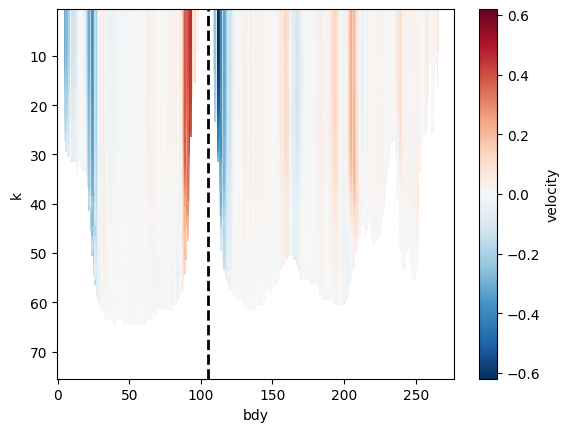

In [9]:
# Plot the time-mean velocity along the OSNAP section:
ds_osnap['velocity'].mean(dim='time_counter').plot(yincrease=False)
plt.axvline(x=ds_osnap['bdy'].where(ds_osnap['glamb'] <= -44).max(), color='k', lw=2, ls='--')

### **Calculating Meridional Overturning Stream Functions along the OSNAP array**

**Finally, let's calculate the meridional overturning stream function in potential density coordinates along the OSNAP array using the `.compute_binned_statistic()` function:**

In [10]:
from nemo_cookbook.stats import compute_binned_statistic

# Calculate volume transport in Sv:
ds_osnap['volume_transport'] = 1E-6 * (ds_osnap['velocity'] * ds_osnap['e1b'] * ds_osnap['e3b'])

# Define potential density bins:
sigma0_bins = np.arange(21, 28.2, 0.01)

# Compute Total OSNAP diapycnal overturning stream function:
ds_osnap['moc_total'] = compute_binned_statistic(vars=[ds_osnap['sigma0']],
                                                 values=ds_osnap['volume_transport'],
                                                 keep_dims=['time_counter'],
                                                 bins=[sigma0_bins],
                                                 statistic='nansum',
                                                 mask=None
                                                 ).cumsum(dim='sigma0_bins')

**Next, let's calculate the meridional overturning stream functions for the OSNAP East and OSNAP West arrays separately.**

In [11]:
# Determine index to split OSNAP West & OSNAP East sections:
station_OWest_OEast = ds_osnap['bdy'].where(ds_osnap['glamb'] <= -44).max()

# OSNAP East diapycnal overturning stream function:
mask_OEast = ds_osnap['bdy'] >= station_OWest_OEast
ds_osnap['moc_east'] = compute_binned_statistic(vars=[ds_osnap['sigma0']],
                                                values=ds_osnap['volume_transport'],
                                                keep_dims=['time_counter'],
                                                bins=[sigma0_bins],
                                                statistic='nansum',
                                                mask=mask_OEast
                                                ).cumsum(dim='sigma0_bins')

# OSNAP West diapycnal overturning stream function:
mask_OWest = ds_osnap['bdy'] < station_OWest_OEast
ds_osnap['moc_west'] = compute_binned_statistic(vars=[ds_osnap['sigma0']],
                                                values=ds_osnap['volume_transport'],
                                                keep_dims=['time_counter'],
                                                bins=[sigma0_bins],
                                                statistic='nansum',
                                                mask=mask_OWest
                                                ).cumsum(dim='sigma0_bins')

ds_osnap

<xarray.Dataset> Size: 7MB
Dimensions:           (bdy: 277, time_counter: 10, k: 75, sigma0_bins: 719)
Coordinates:
  * bdy               (bdy) int64 2kB 0 1 2 3 4 5 6 ... 271 272 273 274 275 276
  * time_counter      (time_counter) datetime64[ns] 80B 2014-07-02T12:00:00 ....
  * k                 (k) int64 600B 1 2 3 4 5 6 7 8 ... 68 69 70 71 72 73 74 75
  * sigma0_bins       (sigma0_bins) float64 6kB 21.01 21.02 ... 28.18 28.19
    glamb             (bdy) float64 2kB -56.75 -56.5 -56.24 ... -4.441 -4.171
    gphib             (bdy) float64 2kB 52.09 52.11 52.13 ... 56.13 56.11 56.09
    depthb            (k, bdy) float64 166kB 0.5058 0.5058 ... 5.902e+03
Data variables:
    i_bdy             (bdy) float64 2kB 927.0 928.0 ... 1.123e+03 1.124e+03
    j_bdy             (bdy) float64 2kB 932.5 932.5 932.5 ... 955.5 955.5 955.5
    flux_type         (bdy) <U1 1kB 'V' 'V' 'V' 'V' 'V' ... 'V' 'U' 'V' 'V' 'V'
    flux_dir          (bdy) int64 2kB 1 1 1 1 1 1 1 1 1 -1 ... 1 1 1 1 1 1 1 1 1
    velocity          (time_counter, k, bdy) float64 2MB dask.array<chunksize=(10, 75, 277), meta=np.ndarray>
    e1b               (bdy) float64 2kB dask.array<chunksize=(277,), meta=np.ndarray>
    e3b               (time_counter, k, bdy) float64 2MB dask.array<chunksize=(10, 75, 277), meta=np.ndarray>
    sigma0            (time_counter, k, bdy) float64 2MB dask.array<chunksize=(10, 75, 277), meta=np.ndarray>
    volume_transport  (time_counter, k, bdy) float64 2MB dask.array<chunksize=(10, 75, 277), meta=np.ndarray>
    moc_total         (time_counter, sigma0_bins) float64 58kB dask.array<chunksize=(10, 719), meta=np.ndarray>
    moc_east          (time_counter, sigma0_bins) float64 58kB dask.array<chunksize=(10, 719), meta=np.ndarray>
    moc_west          (time_counter, sigma0_bins) float64 58kB dask.array<chunksize=(10, 719), meta=np.ndarray>

**Notice that the resulting Dataset includes dask arrays, so we haven't actually computed the diapycnal overturning yet. To do this, we need to call the ``.compute()`` method:**

In [13]:
ds_osnap = ds_osnap.compute()

### **Visualising the time-mean diapycnal overturning stream functions**

**Finally, let's visualise the results by plotting the time-mean OSNAP overturning stream functions in potential density-coordinates:**

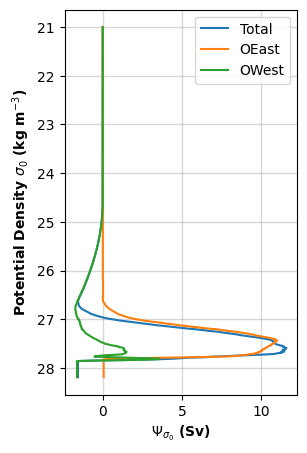

In [14]:
# Plot time-mean diapycnal overturning stream functions along the OSNAP section:
plt.figure(figsize=(3, 5))
plt.grid(True, lw=1, color='0.5', alpha=0.3)
ds_osnap['moc_total'].mean(dim='time_counter').plot(yincrease=False, y='sigma0_bins', label='Total')
ds_osnap['moc_east'].mean(dim='time_counter').plot(yincrease=False, y='sigma0_bins', label='OEast')
ds_osnap['moc_west'].mean(dim='time_counter').plot(yincrease=False, y='sigma0_bins', label='OWest')

plt.xlabel("$\\Psi_{\\sigma_0}$ (Sv)", fontdict={"size": 10, "weight": "bold"})
plt.ylabel("Potential Density $\\sigma_0$ (kg m$^{-3}$)", fontdict={"size": 10, "weight": "bold"})
plt.legend()